In [24]:
# using DBSCAN this time -- left turns
from pathlib import Path
from itertools import product

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler


In [25]:
here = Path.cwd()
root = next(p for p in [here, *here.parents] if (p / "data" / "processed").exists())

#creating 2 columns to identify source file and if ios or android
df = pd.read_csv(root / "data" / "processed" / "android" / "state1_clean.csv", header=0)
print(df.shape)
df.head() 

(1093, 15)


,is_ios,source_file,eventType,eventSampleSpeed,eventDurationSeconds,eventMilesDriven,eventSensorDetectionMthd,eventGPSSignalStrength,eventStartSpeed,eventEndSpeed,memsMedianHorizontalNorm,gyro_angular_change_per_second,gyroAngleChange,mems_radius,eventSpeedChange
0,0,android_turns.csv,4.0,10.394929,7.244125,0.016991,2.0,1.480796,17.323687,6.789408,1.046972,9.521707,69.319600,22.941639,-10.534279
1,0,android_turns.csv,4.0,9.401910,7.497719,0.016103,2.0,1.693853,6.197542,10.101060,1.153392,11.245602,84.723694,20.737572,3.903518
2,0,android_turns.csv,5.0,11.290954,4.244563,0.008359,2.0,21.173470,11.229438,9.081976,5.708309,24.616348,105.462135,18.996666,-2.147462
3,0,android_turns.csv,5.0,12.743101,3.173500,0.007654,1.0,15.306123,10.714942,13.421639,3.099853,17.929585,57.610783,23.959110,2.706697
4,0,android_turns.csv,5.0,8.986107,5.990321,0.013587,0.0,19.387754,2.729067,20.937756,1.197121,2.787075,16.806042,91.713660,18.208689


In [26]:
df.drop(columns=['source_file'], inplace=True)

df = df[(df['eventType'] == 5)]
sub_df = df.drop(columns=['is_ios', 'eventType', 'eventSampleSpeed', 'eventSensorDetectionMthd', 'eventGPSSignalStrength'])
print(sub_df.shape)
print(sub_df.columns.to_list())
sub_df.head()

(574, 9)
['eventDurationSeconds', 'eventMilesDriven', 'eventStartSpeed', 'eventEndSpeed', 'memsMedianHorizontalNorm', 'gyro_angular_change_per_second', 'gyroAngleChange', 'mems_radius', 'eventSpeedChange']


,eventDurationSeconds,eventMilesDriven,eventStartSpeed,eventEndSpeed,memsMedianHorizontalNorm,gyro_angular_change_per_second,gyroAngleChange,mems_radius,eventSpeedChange
2,4.244563,0.008359,11.229438,9.081976,5.708309,24.616348,105.462135,18.996666,-2.147462
3,3.173500,0.007654,10.714942,13.421639,3.099853,17.929585,57.610783,23.959110,2.706697
4,5.990321,0.013587,2.729067,20.937756,1.197121,2.787075,16.806042,91.713660,18.208689
5,3.983969,0.013818,10.106580,16.496264,2.043621,17.628649,70.870450,3.472010,6.389684
7,2.737719,0.008573,9.529365,10.491248,1.173136,11.777087,32.709633,9.324203,0.961883


In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sub_df) 

In [28]:
eps_values = np.linspace(0.1, 2.0, 20)
min_samples_values = range(2, 21)

results = []

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms).fit(X_scaled)
        labels = db.labels_

        # Compute cluster metrics
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_pct = n_noise / len(labels)

        if n_clusters < 2:
            sil = np.nan
        else:
            sil = silhouette_score(X_scaled, labels)

        results.append({
            "eps": eps,
            "min_samples": ms,
            "silhouette": sil,
            "n_clusters": n_clusters,
            "noise_pct": noise_pct
        })
results_df = pd.DataFrame(results)

sil_pivot = results_df.pivot(index="min_samples", columns="eps", values="silhouette")
noise_pivot = results_df.pivot(index="min_samples", columns="eps", values="noise_pct")
clusters_pivot = results_df.pivot(index="min_samples", columns="eps", values="n_clusters")

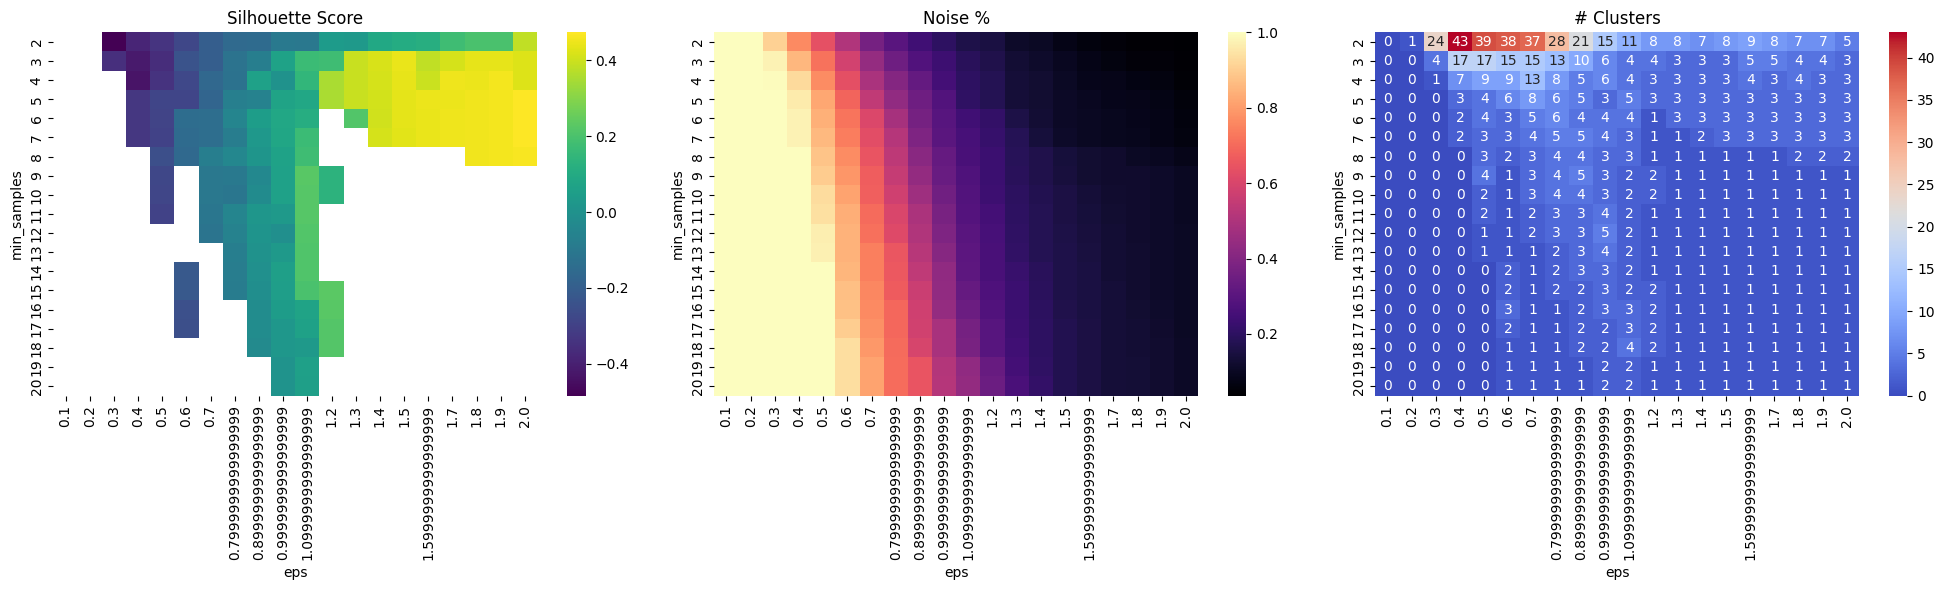

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.heatmap(
    sil_pivot,
    ax=axes[0],
    cmap="viridis",
    cbar=True,
    annot=False
)
axes[0].set_title("Silhouette Score")
axes[0].set_xlabel("eps")
axes[0].set_ylabel("min_samples")

sns.heatmap(
    noise_pivot,
    ax=axes[1],
    cmap="magma",
    cbar=True,
    annot=False
)
axes[1].set_title("Noise %")
axes[1].set_xlabel("eps")
axes[1].set_ylabel("min_samples")

sns.heatmap(
    clusters_pivot,
    ax=axes[2],
    cmap="coolwarm",
    cbar=True,
    annot=True,  # number of clusters is usually small, so annotation helps
    fmt=".0f"
)
axes[2].set_title("# Clusters")
axes[2].set_xlabel("eps")
axes[2].set_ylabel("min_samples")

plt.tight_layout()
plt.show()